🔍 Carregando dataset MFCC para teste SVM...
Total: 36975 arquivos (Real=19999, Fake=16976)
Extraindo MFCC... 100.00% (36975/36975)

📦 Concluído em 464.25s
📌 TAMANHO TESTE: (7182, 40) (7182,)
📁 Carregando modelo SVM MFCC...
✅ Modelo carregado!



/Users/moniquecavalcanti/Documents/POLI/TCC/venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


====== CLASSIFICATION REPORT (SVM) ======
              precision    recall  f1-score   support

        Real       0.78      0.92      0.85      4000
        Fake       0.88      0.68      0.76      3182

    accuracy                           0.81      7182
   macro avg       0.83      0.80      0.81      7182
weighted avg       0.82      0.81      0.81      7182

🎯 Accuracy: 0.8149540517961571 

🧱 Matriz de Confusão:
[[3698  302]
 [1027 2155]]

📈 AUC ROC: 0.9398


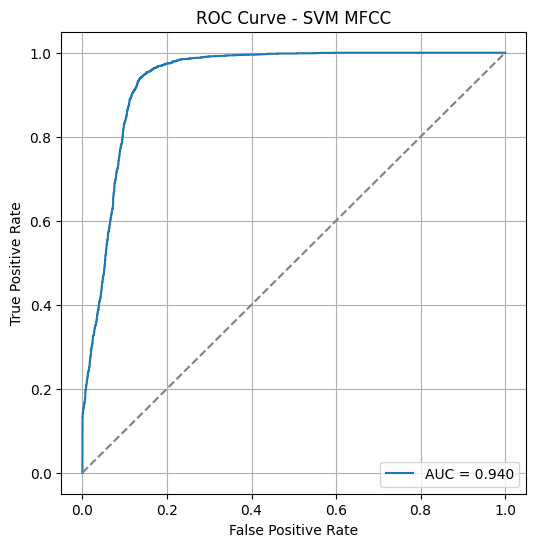

In [7]:
# ======================================================
# 1. Importações
# ======================================================
import os
import numpy as np
import librosa
import soundfile as sf
import joblib
import scipy.fft
import time
from tqdm import tqdm
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    roc_curve, 
    auc
)

# ======================================================
# 2. Configurações
# ======================================================
DATASET_DIR = ""  # <-- MESMO DIRETÓRIO USADO NA CNN E NA EXTRAÇÃO MFCC
REAL_DIR = os.path.join(DATASET_DIR, "real")
FAKE_DIR = os.path.join(DATASET_DIR, "fake")

SVM_MODEL_PATH = "svm_mfcc.pkl"  # <-- Caminho do seu modelo treinado

SAMPLE_RATE = 16000
N_MFCC = 40

# ======================================================
# 3. Funções auxiliares
# ======================================================
def load_audio(path):
    wav, sr = sf.read(path)
    if wav.ndim > 1:
        wav = wav.mean(axis=1)
    if sr != SAMPLE_RATE:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=sr, target_sr=SAMPLE_RATE)
    return wav.astype(np.float32)

def extract_mfcc_mean(wav):
    mfcc = librosa.feature.mfcc(y=wav, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
    return np.mean(mfcc, axis=1)

def count_audio_files(root):
    total = 0
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".wav", ".flac", ".mp3")):
                total += 1
    return total

# ======================================================
# 4. Carregar dataset com estrutura igual à CNN
# ======================================================
def load_dataset_mfcc(real_dir, fake_dir):

    total_real = count_audio_files(real_dir)
    total_fake = count_audio_files(fake_dir)
    total_files = total_real + total_fake
    print(f"Total: {total_files} arquivos (Real={total_real}, Fake={total_fake})")

    X, y, persons = [], [], []
    loaded = 0

    for label_dir, label in [(real_dir, 0), (fake_dir, 1)]:
        for person in os.listdir(label_dir):
            person_path = os.path.join(label_dir, person)

            if os.path.isdir(person_path):
                for root, _, files in os.walk(person_path):
                    for f in files:
                        if f.lower().endswith((".wav",".flac",".mp3")):
                            path = os.path.join(root,f)

                            wav = load_audio(path)
                            feat = extract_mfcc_mean(wav)

                            X.append(feat)
                            y.append(label)
                            persons.append(person)

                            loaded += 1
                            percent = (loaded / total_files) * 100
                            print(f"\rExtraindo MFCC... {percent:.2f}% ({loaded}/{total_files})", end="")

    print("\n")
    return np.array(X), np.array(y), np.array(persons)

# ======================================================
# 5. Carregar dataset
# ======================================================
print("🔍 Carregando dataset MFCC para teste SVM...")
start = time.time()
X, y, persons = load_dataset_mfcc(REAL_DIR, FAKE_DIR)
print(f"📦 Concluído em {time.time()-start:.2f}s")

# ======================================================
# 6. Criar conjunto de teste baseado em SPEAKER (igual à CNN)
# ======================================================
from sklearn.model_selection import train_test_split

unique_persons = np.unique(persons)
_, test_persons = train_test_split(unique_persons, test_size=0.2, random_state=42)

test_mask = np.isin(persons, test_persons)
X_test = X[test_mask]
y_test = y[test_mask]

print("📌 TAMANHO TESTE:", X_test.shape, y_test.shape)

# ======================================================
# 7. Carregar e avaliar modelo SVM
# ======================================================
print("📁 Carregando modelo SVM MFCC...")
svm = joblib.load(SVM_MODEL_PATH)
print("✅ Modelo carregado!\n")

y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)[:, 1]

print("====== CLASSIFICATION REPORT (SVM) ======")
print(classification_report(y_test, y_pred, target_names=["Real","Fake"]))

print("🎯 Accuracy:", accuracy_score(y_test, y_pred), "\n")

print("🧱 Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# ======================================================
# 8. Curve ROC + AUC
# ======================================================
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print(f"\n📈 AUC ROC: {roc_auc:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM MFCC")
plt.legend()
plt.grid()
plt.show()


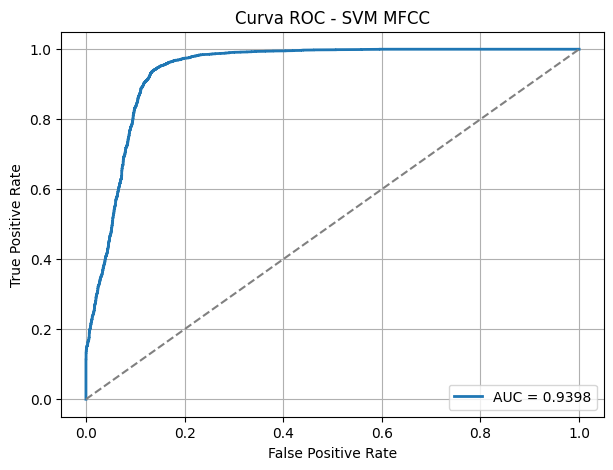

AUC (Área sob a Curva ROC): 0.9398


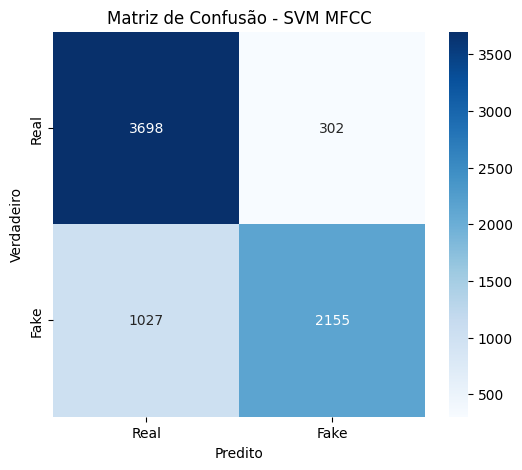

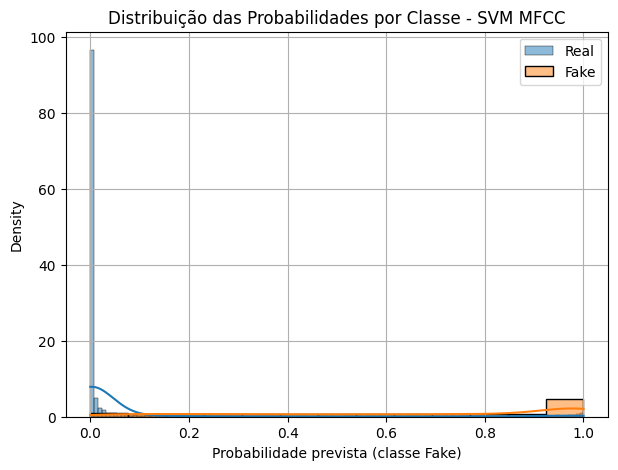

===== MÉTRICAS COMPLEMENTARES =====
Precisão (Precision): 0.8771
Recall (Sensibilidade): 0.6772
F1-Score: 0.7643
MAE das Probabilidades: 0.2016

===== DESEMPENHO DO MODELO SVM =====
Tempo médio por amostra: 0.424 ms
Amostras por segundo (FPS): 2360.38


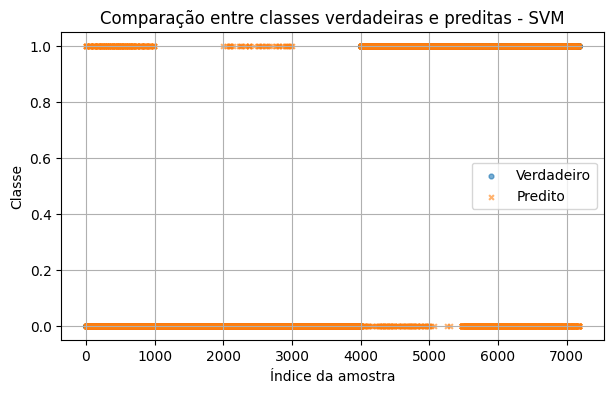

In [8]:
# =====================================================
# 9. Relatórios Avançados e Gráficos para o TCC (SVM)
# =====================================================
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, mean_absolute_error
import numpy as np
import time

# =====================================================
# 1. Curva ROC
# =====================================================
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM MFCC")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC (Área sob a Curva ROC): {roc_auc:.4f}")


# =====================================================
# 2. Matriz de Confusão
# =====================================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Matriz de Confusão - SVM MFCC")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


# =====================================================
# 3. Distribuição das Probabilidades
# =====================================================
plt.figure(figsize=(7, 5))
sns.histplot(y_score[y_test == 0], label="Real", kde=True, stat="density")
sns.histplot(y_score[y_test == 1], label="Fake", kde=True, stat="density")
plt.title("Distribuição das Probabilidades por Classe - SVM MFCC")
plt.xlabel("Probabilidade prevista (classe Fake)")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================
# 4. Métricas complementares
# =====================================================
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
mae       = mean_absolute_error(y_test, y_score)

print("===== MÉTRICAS COMPLEMENTARES =====")
print(f"Precisão (Precision): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MAE das Probabilidades: {mae:.4f}")


# =====================================================
# 5. Tempo de inferência do SVM
# =====================================================
start = time.time()
_ = svm.predict(X_test)
end = time.time()

avg_time = (end - start) / len(X_test)
fps = 1 / avg_time

print("\n===== DESEMPENHO DO MODELO SVM =====")
print(f"Tempo médio por amostra: {avg_time*1000:.3f} ms")
print(f"Amostras por segundo (FPS): {fps:.2f}")


# =====================================================
# 6. Comparação Verdadeiro vs Predito
# =====================================================
plt.figure(figsize=(7, 4))
plt.scatter(range(len(y_test)), y_test, s=12, alpha=0.6, label="Verdadeiro", marker="o")
plt.scatter(range(len(y_pred)), y_pred, s=12, alpha=0.6, label="Predito", marker="x")
plt.title("Comparação entre classes verdadeiras e preditas - SVM")
plt.xlabel("Índice da amostra")
plt.ylabel("Classe")
plt.legend()
plt.grid(True)
plt.show()
